In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read gene expression
x = pd.read_csv('/Users/hclimente/data/single_cell/habib/DATA_MATRIX_LOG_TPM.txt', sep = '\t')
featnames = x.pop('GENE')

# read phenotypes
meta = pd.read_csv('/Users/hclimente/data/single_cell/habib/CLUSTER_AND_SUBCLUSTER_INDEX.txt', sep = '\t')
meta = meta.set_index('NAME')
cell_lines = meta['CLUSTER'].to_dict()
labels = np.array([ cell_lines.get(c,None) for c in x.columns ])

# remove unknown clusters
x = x.values[:,labels != 'Non']
labels = labels[labels != 'Non']
y = pd.factorize(labels)[0]

# subset expression to selected features
hl = pd.read_csv('../results/single_cell/habib_hsic_lasso_C=50_SELECT=50_M=3_B=10.txt', sep = '\t', header=None)
hl = hl.head(n=20)
hl = np.array(hl).flatten()
x_hl = x[[ x in hl for x in featnames ]]

# Supervised learning

### HSIC Lasso output

In [3]:
df = pd.DataFrame(x[[ x in hl for x in featnames ], :].T)
df.columns = featnames[[ x in hl for x in featnames ]]
df = df[hl]
df['cell'] = labels
df.groupby('cell'). mean()

GENE,Gm15127,Hk1os,Klhl1,Mir670,Pou3f1,Lyzl6,Spaca4,Gm28040,Tmem45b,Igkv1-88,C730002L08Rik,Olfr641,Gm5082,Otp,Cubn,Gm16350,0610012D04Rik,Zfp647,Sbk2,Lce1l
cell,,,,,,,,,,,,,,,,,,,,
CA1,0.000000,0.143226,0.382858,0.051348,1.954400,0.036877,0.000000,0.000000,0.089903,0.033303,0.556594,0.000000,0.000000,0.023994,0.077645,0.040310,0.111032,0.347548,0.035510,0.000000
CA2,0.264860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154372,0.000000,0.000000,0.000000,0.000000,0.000000,0.214581,0.000000,0.000000,0.157884,0.000000,0.000000
CA3,0.000000,0.152743,0.268500,0.000000,0.000000,0.000000,0.000000,0.000000,0.116162,0.000000,0.140405,0.000000,0.060905,0.000000,0.576068,0.000000,0.000000,0.065054,0.078081,0.000000
DG,0.058243,0.063293,0.035224,0.000000,0.171397,0.000000,0.007365,0.031869,0.058503,0.000000,0.008584,0.000000,0.000000,0.004166,0.052537,0.010019,0.000000,0.270421,0.014259,0.000000
Ependymal,0.213800,0.000000,0.184000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146880,0.000000,0.000000,0.000000,0.000000,0.000000,0.295080,0.000000,0.000000,0.250800,0.000000,0.000000
GABAergic,0.042722,0.050459,0.151030,0.000000,0.085211,0.000000,0.054165,0.088165,0.047165,0.000000,0.025000,0.046797,0.000000,0.023090,0.080271,0.195158,0.000000,0.342120,0.000000,0.000000
Glia,0.214564,0.081749,0.116184,0.000000,0.437313,0.000000,0.000000,0.000000,0.185944,0.000000,0.074492,0.000000,0.000000,0.000000,0.168905,0.041654,0.000000,0.353609,0.000000,0.039486


## Random forest

In [4]:
clf = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

cv_clf = GridSearchCV(clf, param_grid, cv=3)
cv_clf.fit(x_hl.T, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 500], 'max_features': ['auto', 'log2'], 'max_depth': [4, 6, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [5]:
importances = cv_clf.best_estimator_.feature_importances_
std = np.std([cv_clf.best_estimator_.feature_importances_ for tree in cv_clf.best_estimator_.estimators_],
              axis=0)

indices = np.argsort(importances)
genes = hl[indices]

Text(0, 0.5, 'Feature importance')

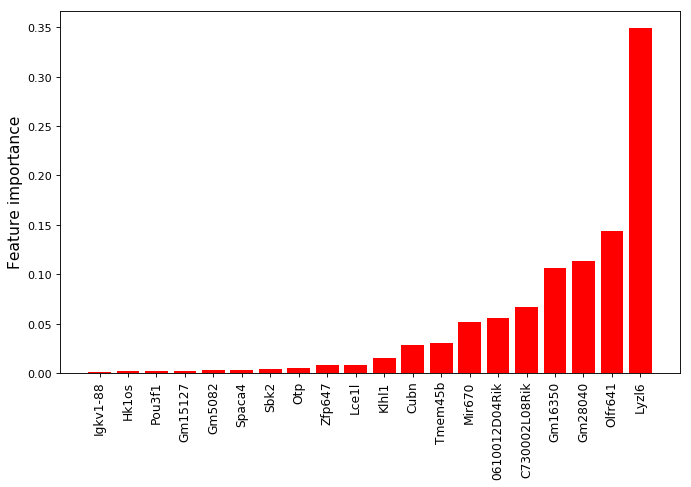

In [6]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

plt.bar(genes, importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(genes)), genes, rotation=90, fontsize=11)
plt.ylabel('Feature importance', fontsize=14)

# Unsupervised learning

In [7]:
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

palette = [ sns.color_palette("hls", 7)[x] for x in y ]

centered_x = (x.T - np.mean(x.T, axis = 0)).T
pca = PCA(n_components = 30).fit(centered_x)

## t-SNE

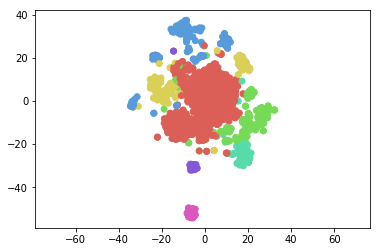

In [8]:
tsne_embedding = TSNE(n_components=2, perplexity=50).fit_transform(pca.components_.T)
plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=palette)
plt.gca().set_aspect('equal', 'datalim')

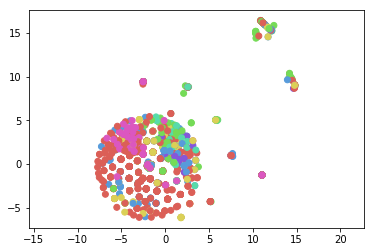

In [9]:
tsne_hl_embedding = TSNE(n_components=2, perplexity=50).fit_transform(x_hl.T)
plt.scatter(tsne_hl_embedding[:,0], tsne_hl_embedding[:,1], c=palette)
plt.gca().set_aspect('equal', 'datalim')

## UMAP

/Users/hclimente/anaconda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


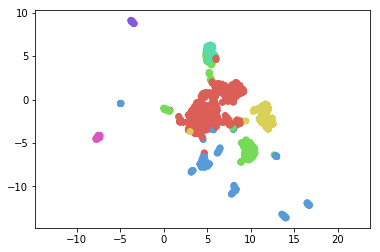

In [10]:
embedding = umap.UMAP(n_neighbors=6).fit_transform(pca.components_.T)

plt.scatter(embedding[:,0], embedding[:,1], c=palette)
plt.gca().set_aspect('equal', 'datalim')

/Users/hclimente/anaconda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


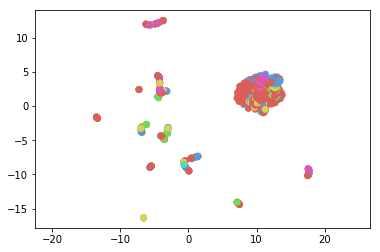

In [11]:
embedding = umap.UMAP(n_neighbors=6).fit_transform(x_hl.T)

plt.scatter(embedding[:,0], embedding[:,1], c=palette)
plt.gca().set_aspect('equal', 'datalim')